In [ ]:
!pip install mediapipe
import numpy as np
import os
from tqdm import tqdm
import pickle
import glob
import argparse
import mediapipe as mp
import cv2 as cv
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 33.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount ('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


### Feature Extraction

In [ ]:
class PoseFeatures:
    def __init__(self, tracking_confidence=None, detection_confidence=0.5, denormalized=True, euclidean_distance=False, static=True):
        self.landmark_names = [
                                'nose',
                                'left_eye_inner', 'left_eye', 'left_eye_outer',
                                'right_eye_inner', 'right_eye', 'right_eye_outer',
                                'left_ear', 'right_ear',
                                'mouth_left', 'mouth_right',
                                'left_shoulder', 'right_shoulder',
                                'left_elbow', 'right_elbow',
                                'left_wrist', 'right_wrist',
                                'left_pinky', 'right_pinky',
                                'left_index', 'right_index',
                                'left_thumb', 'right_thumb',
                                'left_hip', 'right_hip',
                                'left_knee', 'right_knee',
                                'left_ankle', 'right_ankle',
                                'left_heel', 'right_heel',
                                'left_foot_index', 'right_foot_index',
                            ]
        self.static = static
        self.denormalized = denormalized
        self.euclidean_distance = euclidean_distance
        self.detection_confidence = detection_confidence
        self.tracking_confidence = tracking_confidence
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles
        self.mp_pose = mp.solutions.pose

    def get_landmarks(self, activities):
        activity_features = []
        activity_label = []
        notdetected = {}
        if self.static:
            with self.mp_pose.Pose(static_image_mode=True, model_complexity=2, min_detection_confidence=self.detection_confidence) as pose:
                for activity in tqdm(activities):
                    label = activity[0].split('/')[-4]
                    instance_features = []
                    for instance in activity:
                        img = cv.imread(instance)
                        results = pose.process(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                        pose_landmark = results.pose_landmarks
                        if pose_landmark is not None:
                            if self.denormalized:
                                frame_height, frame_width = img.shape[0], img.shape[1]
                                landmarks = np.array(
                                                [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                                for lmk in pose_landmark.landmark],
                                                dtype=np.float32)
                            else:
                                landmarks = np.array(
                                                [[lmk.x, lmk.y, lmk.z ]
                                                for lmk in pose_landmark.landmark],
                                                dtype=np.float32)
                            ## normalize based on pose_size
                            norm_landmarks = self.pose_normalize_landmarks(landmarks)
                            ## calculate distances
                            landmark_distances = self.get_distance_values(norm_landmarks)

                            ## append naval and node landmark as well ### new addition, 51 + 6 features
                            naval = landmarks[self.landmark_names.index('nose')]
                            pose_center = self.pose_center(landmarks)
                            extra_features = np.vstack((naval, pose_center)) / np.array([frame_width, frame_height, frame_width])
                            landmark_distances = np.vstack((landmark_distances, extra_features))

                            # if euclidean distance needs to be calculated
                            if self.euclidean_distance:
                                landmark_distances = np.linalg.norm(landmark_distances, axis=1)
                        else:
                            notdetected[label] = notdetected.get(label, 0) + 1

                        ## flatten and append to instance_features
                        instance_features.append(landmark_distances.flatten())
                    ## make instance_features as an array and append to activity_features
                    activity_features.append(np.stack(instance_features, axis=0))
                    ## maintain a label list
                    activity_label.append(label)

        return notdetected, activity_features, activity_label

    def pose_normalize_landmarks(self, landmarks):
        pose_center = self.pose_center(landmarks)
        pose_size = self.pose_size(landmarks, pose_center)
        return (landmarks-pose_center)/pose_size

    def pose_center(self, landmarks):
        return (landmarks[self.landmark_names.index('left_hip')] + landmarks[self.landmark_names.index('right_hip')]) * 0.5

    def pose_size(self, landmarks, pose_center):
        shoulder_center = (landmarks[self.landmark_names.index('left_shoulder')] + landmarks[self.landmark_names.index('right_shoulder')]) * 0.5
        # torso_size
        torso_size = np.linalg.norm(shoulder_center - pose_center)
        # max variance from pose_center
        max_var = np.max(np.linalg.norm(landmarks - pose_center, axis=1))
        # pose_size
        pose_size = max(torso_size, max_var)
        return pose_size

    def get_distance_values(self, landmarks):
        shoulder_center = (landmarks[self.landmark_names.index('left_shoulder')] + landmarks[self.landmark_names.index('right_shoulder')]) * 0.5
        pose_center = self.pose_center(landmarks)
        landmark_distances = np.array([
            self.cal_distance(pose_center, shoulder_center),
            self.cal_distance(landmarks[self.landmark_names.index('nose')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('nose')], landmarks[self.landmark_names.index('left_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_ear')], landmarks[self.landmark_names.index('left_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_ear')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_knee')], landmarks[self.landmark_names.index('right_knee')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_ankle')], landmarks[self.landmark_names.index('right_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_hip')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_hip')], landmarks[self.landmark_names.index('left_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_elbow')], landmarks[self.landmark_names.index('right_elbow')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_wrist')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_shoulder')], landmarks[self.landmark_names.index('right_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_shoulder')], landmarks[self.landmark_names.index('left_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_hip')], landmarks[self.landmark_names.index('right_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_hip')], landmarks[self.landmark_names.index('left_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_shoulder')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_shoulder')], landmarks[self.landmark_names.index('left_wrist')]),
        ]
        )
        return landmark_distances

    def cal_distance(self, from_lmk, to_lmk):
        return from_lmk - to_lmk

In [ ]:
## Total Breakdown
dataset_path = "/content/gdrive/MyDrive/Dataset"
tots = {}
for p in sorted(glob.glob(dataset_path +'/*')):
    total_f = len(glob.glob(p+'/*/*/*.png'))
    k = p.split('/')[-1]
    tots[k] = total_f
print(tots)

{'Falling': 1017, 'Pain': 1349, 'Sitting': 1596, 'Sleeping': 1498, 'Standing': 1202, 'Walking': 2051}


In [ ]:

activities = sorted(glob.glob(dataset_path+'/*/*/*')) # /activity/act_inst/angle_or_shots/*.png
activity_list = []
for activity in activities:
    instances = glob.glob(activity+'/*.png')
    instances = sorted(instances, key=lambda x: int(x.split('/')[-1].split('.')[0]))
    instance_list = []
    for instance in instances:
        instance_list.append(instance)
    activity_list.append(instance_list)
posFeat = PoseFeatures(detection_confidence=0.1)
notdetected, activity_features, activity_label = posFeat.get_landmarks(activity_list)

100%|██████████| 136/136 [1:00:04<00:00, 26.50s/it]


In [ ]:
total = len(glob.glob(dataset_path+'/*/*/*/*.png'))
not_detected = sum(notdetected.values())
print(notdetected)
print(f"TotalFrames: {total}, NotDetected: {not_detected}")
for f in activity_features:
    assert f.shape[0] >= 30, f"detected length of frames less than 30"

{'Falling': 231, 'Pain': 309, 'Sitting': 97, 'Sleeping': 197, 'Standing': 125, 'Walking': 433}
TotalFrames: 8713, NotDetected: 1392


In [ ]:
assert len(activity_features) == len(activity_label), f"label length: {len(activity_label)} and feature length: {len(activity_features)} do not match"
path = "/content/gdrive/MyDrive/patientActivityRec/patientActivityRec"
feat_path = os.path.join(path, 'Features')
os.makedirs(feat_path, exist_ok=True)
with open(os.path.join(feat_path, 'features_naval_center.pkl'), 'wb') as f:
    pickle.dump(activity_features, f)
with open(os.path.join(feat_path, 'classlabels_naval_center.pkl'), 'wb') as f:
    pickle.dump(activity_label, f)

In [ ]:
labels = {0: 'Falling', 1: 'Pain', 2: 'Sitting', 3: 'Sleeping', 4: 'Standing', 5: 'Walking'}

### Training

In [ ]:
!pip install pytorch_model_summary
import torch
import torch.nn as nn
from torch.optim import SGD, Adam, RMSprop
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from pytorch_model_summary import summary


In [ ]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.has_mps else 'cpu')
# failing to work on mps
if device == 'mps':
    device = 'cpu'
print(f"Using: {device}")

Using: cpu


<ipython-input-9-efe3351b0082>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.has_mps else 'cpu')


In [ ]:
class ActivityDataset(Dataset):
    def __init__(self, sequence_length, feature_path, label_path):
        self.sequnce_length = sequence_length
        self.label_dict = {'Falling': 0, 'Pain': 1, 'Sitting': 2, 'Sleeping': 3, 'Standing': 4, 'Walking': 5}
        with open(feature_path, 'rb') as f:
            self.activity_frames = pickle.load(f)
        with open(label_path, 'rb') as f:
            self.labels = pickle.load(f)

    def __len__(self):
        return len(self.activity_frames)

    def __getitem__(self, idx):
        act_frame = self.activity_frames[idx]
        label = self.label_dict[self.labels[idx]]
        # take random frames starting at start_index from act_frame
        start_index = np.random.randint(low = 0, high = max(1, act_frame.shape[0] - self.sequnce_length))
        frame_inps = act_frame[start_index:start_index+self.sequnce_length, :] # 30 x 51
        return torch.tensor(frame_inps).double(), torch.tensor(label).double()

In [ ]:
sequence_length = 30 # n_frames to consider
batch_size = 8

path = "/content/gdrive/MyDrive/patientActivityRec/patientActivityRec"
feat_path = os.path.join(path, 'Features')
feature_path = os.path.join(feat_path, 'features_naval_center.pkl')
label_path = os.path.join(feat_path, 'classlabels_naval_center.pkl')
trainDataset = ActivityDataset(sequence_length, feature_path, label_path)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

In [ ]:
class ActivityLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0, bidirectional=False, batch_first=True):
        super(ActivityLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=batch_first, bidirectional=bidirectional)
        if bidirectional:
            self.fc = nn.Sequential(nn.Linear(2*self.hidden_size, num_classes),
                                    nn.Softmax())
        else:
            self.fc = nn.Sequential(nn.Linear(self.hidden_size, num_classes),
                                    nn.Softmax())

    def forward(self, x):
        # input_shape: batch x seq_len x in_features
        # Initail states
        d = 2 if self.bidirectional else 1
        h0 = torch.zeros(d*self.num_layers, x.size(0), self.hidden_size).double().to(device)
        c0 = torch.zeros(d*self.num_layers, x.size(0), self.hidden_size).double().to(device)

        # forward propagate LSTM
        out, (_, _) = self.lstm(x, (h0, c0)) # batch x seq_len x d * H_size, [H_size = hidden_size*2 if bidirection else hidden_size]

        # send last hidden state to linear layer
        # known issue with mps device, does not switch batch and seq dimension even when batch_first=True
        # works fine on cpu and cuda
        if device == 'mps':
            out = self.fc(out[-1, :, :])
        else:
            out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_size = 57 # 51 distances + 3 coordinates for naval points + 3 coordinates for pose center
hidden_size = 128
num_layers = 2
label_dict = {'Falling': 0, 'Pain': 1, 'Sitting': 2, 'Sleeping': 3, 'Standing': 4, 'Walking': 5}
num_classes = len(label_dict)

model = ActivityLSTM(input_size, hidden_size, num_layers, num_classes, dropout=0.3)
model.double().to(device)

ActivityLSTM(
  (lstm): LSTM(57, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=6, bias=True)
    (1): Softmax(dim=None)
  )
)

In [ ]:
# print(summary(model, torch.zeros((4, 30, 51)).to(device)))

In [ ]:
learning_rate = 2e-4
optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
scheduler = MultiStepLR(optimizer, milestones=[50, 100], gamma=0.5)

In [ ]:
max_epoch = 120
tensorboardPath = os.path.join(path, "tensorboard")
os.makedirs(tensorboardPath, exist_ok=True)
summary = SummaryWriter(os.path.join(tensorboardPath,f"e{max_epoch}_l{learning_rate}_seqlen30"))
for epoch in range(1, max_epoch+1):
    correct = 0
    total = 0
    running_loss = 0
    for i, (data, labels) in enumerate(trainLoader):
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)

        loss = criterion(outputs, labels.type(torch.LongTensor))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Epoch:{epoch}, Train Accuracy: {round(correct/total, 3)}, Train Loss: {round(running_loss/total,3)}")
    summary.add_scalars('Training', {'Loss': running_loss/total, 'Accuracy': correct/total}, epoch)
    scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch:1, Train Accuracy: 0.118, Train Loss: 0.224
Epoch:2, Train Accuracy: 0.309, Train Loss: 0.223
Epoch:3, Train Accuracy: 0.419, Train Loss: 0.218
Epoch:4, Train Accuracy: 0.456, Train Loss: 0.204
Epoch:5, Train Accuracy: 0.566, Train Loss: 0.188
Epoch:6, Train Accuracy: 0.559, Train Loss: 0.184
Epoch:7, Train Accuracy: 0.551, Train Loss: 0.183
Epoch:8, Train Accuracy: 0.551, Train Loss: 0.183
Epoch:9, Train Accuracy: 0.566, Train Loss: 0.18
Epoch:10, Train Accuracy: 0.574, Train Loss: 0.18
Epoch:11, Train Accuracy: 0.596, Train Loss: 0.178
Epoch:12, Train Accuracy: 0.654, Train Loss: 0.176
Epoch:13, Train Accuracy: 0.647, Train Loss: 0.175
Epoch:14, Train Accuracy: 0.699, Train Loss: 0.174
Epoch:15, Train Accuracy: 0.706, Train Loss: 0.172
Epoch:16, Train Accuracy: 0.706, Train Loss: 0.17
Epoch:17, Train Accuracy: 0.713, Train Loss: 0.168
Epoch:18, Train Accuracy: 0.713, Train Loss: 0.167
Epoch:19, Train Accuracy: 0.721, Train Loss: 0.165
Epoch:20, Train Accuracy: 0.757, Train Loss

In [ ]:
#save model
model_path = os.path.join(path, "model_ckpt")
os.makedirs(model_path, exist_ok=True)
model_ckpt = "activity_lstm_adam_naval_centers.pth"
torch.save(model.state_dict(), os.path.join(model_path, model_ckpt))

### Validation

In [ ]:
class validation_PoseFeatures:
    def __init__(self, denormalized=True, euclidean_distance=False):
        self.landmark_names = [
                                'nose',
                                'left_eye_inner', 'left_eye', 'left_eye_outer',
                                'right_eye_inner', 'right_eye', 'right_eye_outer',
                                'left_ear', 'right_ear',
                                'mouth_left', 'mouth_right',
                                'left_shoulder', 'right_shoulder',
                                'left_elbow', 'right_elbow',
                                'left_wrist', 'right_wrist',
                                'left_pinky', 'right_pinky',
                                'left_index', 'right_index',
                                'left_thumb', 'right_thumb',
                                'left_hip', 'right_hip',
                                'left_knee', 'right_knee',
                                'left_ankle', 'right_ankle',
                                'left_heel', 'right_heel',
                                'left_foot_index', 'right_foot_index',
                            ]

        self.denormalized = denormalized
        self.euclidean_distance = euclidean_distance

    def get_video_features(self, landmarks, frame_height, frame_width):
        ## normalize based on pose_size
        norm_landmarks = self.pose_normalize_landmarks(landmarks)
        ## calculate distances
        landmark_distances = self.get_distance_values(norm_landmarks)

        ## append naval and node landmark as well ### new addition, 51 + 6 features
        naval = landmarks[self.landmark_names.index('nose')]
        pose_center = self.pose_center(landmarks)
        extra_features = np.vstack((naval, pose_center)) / np.array([frame_width, frame_height, frame_width])
        landmark_distances = np.vstack((landmark_distances, extra_features))

        # if euclidean distance needs to be calculated
        if self.euclidean_distance:
            landmark_distances = np.linalg.norm(landmark_distances, axis=1)
        return landmark_distances.flatten()


    def pose_normalize_landmarks(self, landmarks):
        pose_center = self.pose_center(landmarks)
        pose_size = self.pose_size(landmarks, pose_center)
        return (landmarks-pose_center)/pose_size

    def pose_center(self, landmarks):
        return (landmarks[self.landmark_names.index('left_hip')] + landmarks[self.landmark_names.index('right_hip')]) * 0.5

    def pose_size(self, landmarks, pose_center):
        shoulder_center = (landmarks[self.landmark_names.index('left_shoulder')] + landmarks[self.landmark_names.index('right_shoulder')]) * 0.5
        # torso_size
        torso_size = np.linalg.norm(shoulder_center - pose_center)
        # max variance from pose_center
        max_var = np.max(np.linalg.norm(landmarks - pose_center, axis=1))
        # pose_size
        pose_size = max(torso_size, max_var)
        return pose_size

    def get_distance_values(self, landmarks):
        shoulder_center = (landmarks[self.landmark_names.index('left_shoulder')] + landmarks[self.landmark_names.index('right_shoulder')]) * 0.5
        pose_center = self.pose_center(landmarks)
        landmark_distances = np.array([
            self.cal_distance(pose_center, shoulder_center),
            self.cal_distance(landmarks[self.landmark_names.index('nose')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('nose')], landmarks[self.landmark_names.index('left_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_ear')], landmarks[self.landmark_names.index('left_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_ear')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_knee')], landmarks[self.landmark_names.index('right_knee')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_ankle')], landmarks[self.landmark_names.index('right_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_hip')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_hip')], landmarks[self.landmark_names.index('left_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_elbow')], landmarks[self.landmark_names.index('right_elbow')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_wrist')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_shoulder')], landmarks[self.landmark_names.index('right_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_shoulder')], landmarks[self.landmark_names.index('left_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_hip')], landmarks[self.landmark_names.index('right_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_hip')], landmarks[self.landmark_names.index('left_ankle')]),
            self.cal_distance(landmarks[self.landmark_names.index('right_shoulder')], landmarks[self.landmark_names.index('right_wrist')]),
            self.cal_distance(landmarks[self.landmark_names.index('left_shoulder')], landmarks[self.landmark_names.index('left_wrist')]),
        ]
        )
        return landmark_distances

    def cal_distance(self, from_lmk, to_lmk):
        return from_lmk - to_lmk

In [ ]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.has_mps else 'cpu')
# failing to work on mps
if device == 'mps':
    device = 'cpu'
print(f"Using: {device}")

### load model
path = "/content/gdrive/MyDrive/patientActivityRec/patientActivityRec"
model_path = os.path.join(path, "model_ckpt")
model_ckpt = "activity_lstm_adam_naval_centers.pth" # "activity_lstm_adam_latest.pth"

model = ActivityLSTM(input_size=57, hidden_size=128, num_layers=2, num_classes=6)

model.load_state_dict(torch.load(os.path.join(model_path, model_ckpt)))
model.double().to(device)
print(f"Model loaded from {os.path.join(model_path, model_ckpt)}")

NameError: name 'torch' is not defined

In [ ]:
labels = {0: 'Falling', 1: 'Pain', 2: 'Sitting', 3: 'Sleeping', 4: 'Standing', 5: 'Walking'}
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

Sitting


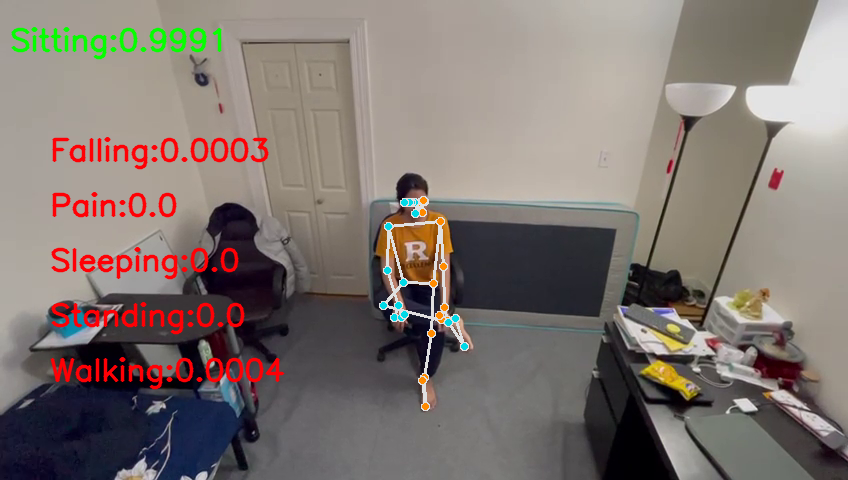

In [ ]:
from google.colab.patches import cv2_imshow

denormalized=True
sequence_len = 30
posFeat = validation_PoseFeatures()
video_path = "/content/gdrive/MyDrive/WhatsApp Video 2024-02-23 at 2.13.38 AM.mp4"
feature_list = []
with mp_pose.Pose(model_complexity=2, min_detection_confidence=0.1) as pose:
    cap = cv.VideoCapture(video_path)
    # Check if camera opened successfully
    if (cap.isOpened() == False):
        raise Exception("Error opening video file")
    # Read until video is completed
    while(cap.isOpened()):
        # capture each frame
        ret, frame = cap.read()
        if ret == True:
            frame.flags.writeable = False
            results = pose.process(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
            pose_landmark = results.pose_landmarks
            if pose_landmark is not None:
                if denormalized:
                    frame_height, frame_width = frame.shape[0], frame.shape[1]
                    landmarks = np.array(
                                    [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                    for lmk in pose_landmark.landmark],
                                    dtype=np.float32)
                else:
                    landmarks = np.array(
                                    [[lmk.x, lmk.y, lmk.z ]
                                    for lmk in pose_landmark.landmark],
                                    dtype=np.float32)
                features = posFeat.get_video_features(landmarks, frame_height, frame_width)
                feature_list.append(features)
                # wait until 30 frames are collected
                if len(feature_list) == 30:
                    input_to_model = torch.tensor(np.stack(feature_list, axis=0)).double().to(device)
                    predictions = model(input_to_model.unsqueeze(0))
                    probs, predicted = torch.max(predictions.data, 1)
                    predicted_lab = labels[predicted.item()]

                    # remove first frame
                    feature_list.pop(0)

                    print(predicted_lab)

                    # display
                    frame.flags.writeable = True
                    mp_drawing.draw_landmarks(
                        frame,
                        results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
                    cv.putText(frame, predicted_lab + ':' + str(round(probs.item(), 4)), (10,50), cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,5), 2, cv.LINE_AA)
                    pos = 1
                    for idx, prob in enumerate(predictions.flatten().tolist()):
                        if idx != predicted.item():
                            pos += 1
                            all_prob = f"{labels[idx]}:{round(prob, 4)}"
                            cv.putText(frame, all_prob, (50,50+pos*55), cv.FONT_HERSHEY_SIMPLEX, 1, (5,0,255), 2, cv.LINE_AA)
                    cv2_imshow(frame)
                    cv.namedWindow("MediaPipe", cv.WINDOW_AUTOSIZE)
                    cv.startWindowThread()
                    k = cv.waitKey(1)
                    if k == ord('q'):
                        cv.destroyWindow("Image")
                        cv.destroyAllWindows()
                        cv.waitKey(1)
                        break
    cap.release()


In [ ]:
activity_features.append(landmark_distances.flatten())
                    # display
                    frame.flags.writeable = True
                    self.mp_drawing.draw_landmarks(
                        frame,
                        results.pose_landmarks,
                        self.mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=self.mp_drawing_styles.get_default_pose_landmarks_style())
                    cv.imshow("MediaPipe", frame)
                    cv.namedWindow("MediaPipe", cv.WINDOW_AUTOSIZE)
                    cv.startWindowThread()
                    k = cv.waitKey(1)
                    if k == ord('q'):
                        break
            cap.release()
            cv.destroyWindow("Image")
            cv.destroyAllWindows()
            cv.waitKey(1)

In [ ]:
total = glob.glob(path + '/*/*/*/*.png')
sum(notdetected.values()), len(total)

(1153, 8445)

In [ ]:
notdetected

{'Falling': 361,
 'Pain': 574,
 'Sitting': 138,
 'Sleeping': 345,
 'Standing': 177,
 'Walking': 128}

In [ ]:
1153, 8445

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [ ]:
i = 0
act_list = sorted(glob.glob(''), key=lambda x: int(x.split('/')[-1].split('.')[0]))
with mp_pose.Pose(static_image_mode=True, model_complexity=2, min_detection_confidence=0.1) as pose:
    for activities in act_list:
        img = cv.imread(activities)
        results = pose.process(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        pose_landmark = results.pose_landmarks
        if pose_landmark is not None:
            i += 1
            # ladnmarks = pose_landmark.landmark
            img.flags.writeable=True
            mp_drawing.draw_landmarks(
                    img,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            print("displaying image")
            cv.imshow("Image", img)
            cv.namedWindow("Image", cv.WINDOW_AUTOSIZE)
            cv.startWindowThread()
            cv.waitKey(0)
            cv.destroyWindow("Image")
            cv.destroyAllWindows()
            cv.waitKey(1)


displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying image
displaying ima

In [ ]:
a = np.array([[0.2, 0.3, 0.4],[0.4, 0.76, 0.88]])
b = np.array([0.23, 0.45, 0.19])

In [ ]:
a = [np.ones(12), np.ones(12), np.ones(12)]

In [ ]:
np.linalg.norm(a, axis=1)

array([0.53851648, 1.22963409])

In [ ]:
a = np.ones((4,3))
a.flatten().shape

(12,)